# Global parameter estimation relaxing the weak promoter approximation.

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).  

In [1]:
# For operating system interaction
import os
import glob
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special

# Library to perform MCMC sampling
import emcee

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Defining the problem

In our first parameter estimation [using MCMC](https://github.com/RPGroup-PBoC/mwc_induction/blob/master/code/analysis/MCMC_parameter_estimation.ipynb) we reported a credible region for the MWC parameters and the fold-change based on the data and the fit to the model. But these estimates didn't include previous characterized uncertainty in the parameters of the model.

For example, to compute the fold-change for each of the RBS mutants we assumed we knew with 100% certainty the mean repressor copy number. This assumption might not be completely truth since in their paper [Garcia and Phillips](http://www.pnas.org/content/108/29/12173.abstract) report the mean $\pm$ standard deviation of the repressor copy number as revealed by multiple measurements of these quantities. The same applies to the repressor binding energies.

The question then becomes how do we include these sources of uncertainty into our fold-change model with induction?

Recall that the theoretical fold-change equation is given by
$$
\text{fold-change} = \left( 1 + \frac{\left( 1 + \frac{c}{1M}\cdot e^{\tilde{k_A}} \right)^2}{\left( 1 + \frac{c}{1M}\cdot e^{\tilde{k_A}} \right)^2 + e^{-\beta \Delta\varepsilon_{AI}}\left( 1 + \frac{c}{1M}\cdot e^{\tilde{k_I}} \right)^2} \frac{R}{N_{NS}}e^{-\beta\Delta\varepsilon_{RA}} \right)^{-1}.
\tag{1}
$$
where $\beta \equiv \frac{1}{k_BT}, $ $c$ is the inducer concentration, $1M$ is a reference concentration, $\Delta\varepsilon_{AI}$ is the energy difference between the active and inactive state conformations, $R$ is the repressor copy number, $N_{NS}$ is the number of non-specific binding sites where the repressor can bind, and $\Delta\varepsilon_{RA}$ is the binding energy of the repressor to the DNA. We conveniently define $\tilde{k}_A \equiv -\log\frac{K_A}{1\text{ M}}$, and $\tilde{k}_I \equiv -\log\frac{K_I}{1\text{ M}}$ to sample the dissociation constants $K_A$ and $K_I$ in log scale since dissociation constants are scale invariant. This means that a change from 10 $\mu M$ to 1 $\mu M$ is an increase in binding as significant as a change from 1 $\mu M$ to 0.1 $\mu M$.

Originally we defined the parameter estimation problem using Bayes theorem as
$$
P(\tilde{k}_A, \tilde{k}_I \mid D) \propto P(D \mid \tilde{k}_A, \tilde{k}_I)P(\tilde{k}_A, \tilde{k}_I),
\tag{2}
$$
where $D$ is all the data composed of independent variables (repressor copy
number $R$, repressor-DNA binding energy $\Delta\varepsilon_{RA}$, and inducer
concentration $c$) and one dependent variable (experimental fold-change), $P(D \mid \tilde{k}_A, \tilde{k}_I)$ is the likelihood of having observed the data given the
parameter values, and $P(\tilde{k}_A, \tilde{k}_I)$ contains all the prior information on these parameters. 

But now to include the uncertainty in the repressor copy number $R$ and the repressor binding energy $\Delta\varepsilon_{RA}$ we need to modify Eq. 2.

## Bayes theorem as a method for learning

The Bayesian framework gives a natural form on how to tackle this problem. Let us focus first on the uncertainty on the repressor copy number measurements. We write our parameter estimation to include a single repressor copy number as a parameter to determine as
\begin{equation}
P(\tilde{k}_A, \tilde{k}_I, R \mid D) \propto P(D \mid \tilde{k}_A, \tilde{k}_I, R) \cdot P(\tilde{k}_A, \tilde{k}_I, R).
\tag{3}
\end{equation}
The second term on the right hand side, the so-called prior, **includes all the information we know before performing the experiment**. For simplicity we assume that the parameters are independent such that we can rewrite this term as

\begin{equation}
P(\tilde{k}_A, \tilde{k}_I, R \mid I) = P(\tilde{k}_A \mid I) \cdot P(\tilde{k}_I \mid I) \cdot P(R \mid I).
\tag{4}
\end{equation}

Usually one does not want to bias the inference with the prior, therefore we are trained to use *maximally uniformative priors*. This is why for our previous model we chose a uniform prior for the $\tilde{k}_A$ and $\tilde{k}_I$ parameteres, i.e.

\begin{align}
P(\tilde{k}_A \mid I) &\propto \frac{1}{\tilde{k}_{A}^\max - \tilde{k}_{A}^\min}, \tag{5} \\
P(\tilde{k}_I \mid I) &\propto \frac{1}{\tilde{k}_{I}^\max - \tilde{k}_{I}^\min}. \tag{6}
\end{align}

But in a sense Bayes theorem is a *model for learning*. What we mean with that is that it naturally allows us to update our parameter estimates after performing an experiment and obtaining data. So in the case when one does not know anything at all about the parameter value these uniformative priors are the right thing to use. But what happens when we have information about the value of some of these parameters from previous experiments? In that case we should include that information in the prior.

### Prior on the parameters to include sources of uncertainty

For the term $P(R \mid I)$ we must include the characterized uncertainty that Garcia and Phillips reported in their paper. As is written in the paper, 
> Immunoblots were used to measure the number of Lac repressors in six strains with different constitutive levels of Lac repressor. Each value corresponds to an average of cultures grown on at least 3 different days. The error bars are the SD of these measurements.

This means that the number they report is the *mean repressor copy number* and the *standard deviation on these measurements*. It is important to clarify that this standard deviation **does not** reflect the single-cell variability of repressors, but the experimental uncertainty when measuring the mean repressor copy number. In other words this standard deviation captures the lack of accuracy when measuring this parameter, not the natural biological noise one expects on a clonal population.

The repressor copy number per cell itself is a *discrete variable*, therefore one could naively think that the prior should be therefore given by a discrete distribution. But we highlight that what Garcia and Phillips measured with their immunoblots was not a single cell measurement, but a bulk measurement of the **mean repressor copy number**, which is not a discrete variable itself. As a matter of fact, from the central limit theorem we know that the distribution of the mean repressor copy number must be Gaussian. Therefore we can write
\begin{equation}
P(R \mid \sigma_R) \approx \frac{1}{\sqrt{2 \pi \sigma_R^2}}\exp \left[ -\frac{(R - R^*)^2}{2 \sigma_R^2}  \right] \; \forall~R > 0,
\tag{7}
\end{equation}
where $\sigma_R$ is the characterized standard deviation that Garcia and Phillips experimentally characterized for each RBS mutant, and $R^*$ is the mean repressor level also characterized experimentally.

If we include this prior for the repressor copy number and an equivalent one for the repressor binding energy, and allow the MCMC walkers to walk on these two new dimensions while fitting the MWC parameters, then the posterior probability for the fold-change will include all of the characterized uncertainty on all parameters. In this way we can properly build the credible region for our predictions.

We can use the same kind of informative prior for the binding energies and use all of the experimental fold-changes to determine the dissociation constatants, the four repressor-DNA binding energies for the four different operators {O1, O2, O3, Oid} and the 6 different mean repressor copy numbers.

We then write Bayes theorem as
\begin{equation}
P(\tilde{k}_A, \tilde{k}_I, \mathbf{R}, \boldsymbol{\Delta\varepsilon_{RA}} \mid D) \propto P(D \mid \tilde{k}_A, \tilde{k}_I, \mathbf{R}, \boldsymbol{\Delta\varepsilon_{RA}})\cdot P(\tilde{k}_A, \tilde{k}_I, \mathbf{R}, \boldsymbol{\Delta\varepsilon_{RA}}),
\tag{8}
\end{equation}
where $\mathbf{R}$ is an array containing the six different repressor
copy numbers to be fit,
$\boldsymbol{\Delta\varepsilon_{RA}}$ is an array
containing the four binding energies to be fit, and $D$ is the experimental
fold-change data. The term $P(\tilde{k}_A, \tilde{k}_I, \mathbf{R}, \boldsymbol{\Delta\varepsilon_{RA}} \mid D)$ is the
parameters probability distributions we aim to compute since it describes the
plausibility of all parameters, taking into account the dependences they might
have with each other. The term $(D \mid \tilde{k}_A, \tilde{k}_I, \mathbf{R}, \boldsymbol{\Delta\varepsilon_{RA}})$ represents the
likelihood of having observed our experimental data given a value of the
parameters. And finally $P(\tilde{k}_A, \tilde{k}_I, \mathbf{R}, \boldsymbol{\Delta\varepsilon_{RA}})$ contains
all the prior information on the value of these parameters.

As before we assume that the deviations of the experimental fold-change from the theoretical predictions are normally distributed with mean zero and standard deviation $\sigma$. That implies that the first term on the right hand side of Eq. 8 can be written as
\begin{align}
P(\tilde{k}_A, \tilde{k}_I, \mathbf{R}, \boldsymbol{\Delta\varepsilon_{RA}}, \sigma \mid D ) = \frac{1}{(2\pi\sigma^2)^{\frac{n}{2}}}\prod\limits_{i=1}^n \exp \left[-\frac{(\mathrm{fc}^{(i)}_{\exp} - \mathrm{fc}(\tilde{k}_A, \tilde{k}_I, R^{(i)}, \Delta\varepsilon_{RA}^{(i)}, c^{(i)}))^2}{2\sigma^2}\right],
\tag{9}
\end{align}
where $\text{fc}^{(i)}_{\text{exp}}$ is the experimental fold-change and
$\mathrm{fc(\cdots)}$ is the theoretical prediction. The product $\prod_{i=1}^n$
captures the assumption that the $n$ data points are independent. Note that
since we assume the errors follow a normal distribution with unknown standard
deviation $\sigma$, this term has to be included as part of the fitting
procedure.

For the prior term $P(\tilde{k}_A, \tilde{k}_I, \mathbf{R}, \boldsymbol{\Delta\varepsilon_{RA}}, \sigma)$ that also includes now the prior information on $\sigma$, we assign uniform priors to $\tilde{k}_A$ and $\tilde{k}_I$ as explained above, as well as Gaussian informative priors to both the repressor copy number and the repressor-DNA binding energies. Finally we assign a Jeffreys prior to $\sigma$ since it is a scaling parameter. All this together gives
\begin{equation}
P(\tilde{k}_A, \tilde{k}_I, \mathbf{R}, \boldsymbol{\Delta\varepsilon_{RA}}, \sigma) \propto \frac{1}{\tilde{k}_{A}^\max - \tilde{k}_{A}^\min} \cdot \frac{1}{\tilde{k}_{I}^\max - \tilde{k}_{I}^\min} \cdot \prod_i \frac{1}{\sqrt{2\pi\sigma_{R_i}^2}} \exp \left(-\frac{(R^{(i)} - \bar{R}^{(i)})^2}{2 \sigma_{R_i}^2} \right)\cdot \prod_j \frac{1}{\sqrt{2\pi\sigma_{\varepsilon_j}^2}} \exp \left(-\frac{(\Delta\varepsilon_{RA}^{(j)} - \Delta\bar{\varepsilon}_{RA}^{(j)})^2}{2 \sigma_{\varepsilon_j}^2} \right) \cdot \frac{1}{\sigma}
\tag{10}
\end{equation}
where the product over all $i$ values represents all six RBS mutants used in this work and the product over all $j$ values represent all four operator sequences used in this work. The terms $\bar{R}^{(i)}$ and $\Delta\bar{\varepsilon}_{RA}^{(j)}$ represent the prior values for the repressor copy numbers and binding energies as reported by Garcia and Phillips.

### The log posterior probability

To implement the MCMC routine we need to compute the log posterior probability. Putting back together our likelihood from Eq. 9 and the prior from Eq. 10, and taking the log gives
\begin{equation}
\ln P(\tilde{k}_A, \tilde{k}_I, R_i, \varepsilon_{RA_j} \mid fc_{\exp_{ijk}}, R_i^*, \sigma_{R_i}, \varepsilon_{RA_j}^*, \sigma_{\varepsilon_{RA_j}}, c_k, \sigma, I) \propto - (n + 1) \ln \sigma + \sum_i \sum_j \sum_k  - \frac{1}{2 \sigma^2} \left(fc_{\exp_{ijk}} - fc(\tilde{k}_A, \tilde{k}_I, R_i, \varepsilon_{RA_j}, c_k) \right)^2 - \frac{\left( R_i - R_i^* \right)^2}{2 \sigma^2_{R_i}} - \frac{\left( \varepsilon_{RA_j} - \varepsilon_{RA_j}^* \right)^2}{2 \sigma^2_{\varepsilon_{RA_j}}} ,
\tag{11}
\end{equation}
where the subindex $i$ lists all the RBS mutants, the subindex $j$ lists all the operators, and the subindex $k$ lists all the IPTG concentrations $c$. $fc_{\exp_{ijk}}$ represents the experimentally determined fold-change, and $n$ is the total number of data points.

In [92]:
def fold_change_log_eRI(iptg, ea, ei, epsilon, R, epsilon_RA, epsilon_RI, n=2,
                    quaternary_state=2, nonspec_sites=4.6E6):
    '''
    Returns the gene expression fold change according to the
    thermodynamic model with the extension that takes into account the
    effect of the inducer.

    Parameter
    ---------
    iptg : array-like.
        Concentrations of inducer on which to evaluate the function
    ea, ei : float.
        Minus log of the dissociation constants of the active and the
        inactive states respectively
    epsilon : float.
        Energy difference between the active and the inactive state
    
    R : array-like.
        Repressor copy number for each of the strains. The length of
        this array should be equal to the iptg array. If only one value
        of the repressor is given it is asssume that all the data points
        should be evaluated with the same repressor copy number
    epsilon_RA : array-like
        Repressor binding energy. The length of this array
        should be equal to the iptg array. If only one value of the
        binding energy is given it is asssume that all the data points
        should be evaluated with the same repressor copy number
    epsilon_RI : float.
        Inactive repressor binding energy   
    quaternary_state: int
        Prefactor in front of R in fold-change. Default is 2
        indicating that there are two functional heads per repressor molecule.
        This value must not be zero.
    nonspec_sites : int
        Number of nonspecific binding sites in the system.
        This value must be greater than 0.

    Returns
    -------
    fold_change : float.
        Gene expression fold change as dictated by the thermodynamic model.

    Raises
    ------
    ValueError
        Thrown if any entry of the IPTG vector, number of repressors,
        quaternary prefactor, or number of nonspecific binding sites is
        negative. This is also thrown if the quaternary
        state  or number of nonspecific binding sites is 0.


   '''
    return (1 + quaternary_state * R / nonspec_sites *
            mwc.pact_log(iptg, ea, ei, epsilon, n) * (1 + np.exp(-epsilon)) *
            np.exp(-epsilon_RA) + \
            quaternary_state * R / nonspec_sites * \
            (1 - mwc.pact_log(iptg, ea, ei, epsilon, n)) * np.exp(-epsilon_RI))**-1

In order to minimize the data frame parsing that the log-posterior has to do when performing the MCMC let's write a pre-processing function that will parse the data once such that the output can be feed to the log-posterior function.

In [93]:
def mcmc_pre_process(df):
    """
    Pre-process the tidy DataFrame to prepare it for the MCMC. This is done
    separately from the log-posterior calculation to speed up the process
    avoiding parsing the DataFrame every evaluation of the posterior.
    Parameteres
    -----------
    df : pandas DataFrame.
        A tidy pandas DataFrame as standardized in the project that contains
        at least the following columns:
        fold_change_A : the experimental fold-change from channel A in the
        flow cytometer.
    IPTG_uM : 1d-array
        Concentrations of the inducer in micromolar. 
    repressors : int
        The mean repressor copy number in copies per cell. 
    delta_repressors : float
        The experimental standard deviation on the mean repressor copy number
    binding_energy : float
        The mean repressor binding energy
    delta_energy : float 
        The experimental standard deviation on the binding energy

    Returns
    -------
    [rep_unique, eps_unique] : list
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    """
    # List the unique variables
    rep_unique = np.sort(df.repressors.unique())
    eps_unique = np.sort(df.binding_energy.unique())
    IPTG_unique = np.sort(df.IPTG_uM.unique())
    
    # determine the number of unique variables
    n_repressor = len(rep_unique)
    n_epsilon_r = len(eps_unique)
    n_IPTG = len(IPTG_unique)
    
    # Depending on the number of parameters determine the indexes of the
    # parameters to fit
    param_idx = np.cumsum([3, n_repressor, n_epsilon_r, n_epsilon_r])
    
    # Sort the data frame such that the log-posterior function can
    # automatically compute the log probability with the right parameters
    # for each data point
    df_sort = df.sort_values(['repressors', 'binding_energy', 'IPTG_uM'])
    data = np.array(df_sort[['fold_change_A', 'IPTG_uM', 
                             'repressors', 'delta_repressors', 
                             'binding_energy', 'delta_energy']])
    return [rep_unique, eps_unique, eps_unique + np.log(1000)], param_idx, data

Now let's define the function to compute the likelihood, the prior and the posterior probability

In [95]:
def log_likelihood(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log-likelihood
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma : first 3 columns.
        repressor copy number : next columns.
        binding energies : final columns.
        The exact position of each of these parameters depends on the number
        of unique repressors and energies as indicated by param_idx.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    log likelihood probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = param[param_idx[0]:param_idx[1]] # Repressor copy numbers
    eps_RA = param[param_idx[1]:param_idx[2]] # Represor energies
    eps_RI = param[param_idx[2]:param_idx[3]] # Represor energies
   
    # Initialize the log_likelihood
    log_like = 0
    # loop through the parameters to fit in order to compute the
    # theoretical fold change using the right parameters for each strain
    for i, r in enumerate(unique_var[0]):
        for j, eps in enumerate(unique_var[1]):
            data_block = data[(data[:, 2]==r) & (data[:, 4]==eps), :]
            # compute the theoretical fold-change
            fc_theory = fold_change_log_eRI(data_block[:, 1],
                                            ea, ei, epsilon,
                                            rep[i], eps_RA[j], eps_RI[j])
            # compute the log likelihood for this block of data
            log_like -=  np.sum((fc_theory - data_block[:, 0])**2) / 2 / sigma**2
            
    return log_like

def log_prior(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log-prior probability
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, p, sigma : first 4 columns.
        repressor copy number : next columns.
        binding energies : final columns.
        The exact position of each of these parameters depends on the number
        of unique repressors and energies as indicated by param_idx.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    log prior probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = param[param_idx[0]:param_idx[1]] # Repressor copy numbers
    eps_RA = param[param_idx[1]:param_idx[2]] # Represor energies
    eps_RI = param[param_idx[2]:param_idx[3]] # Represor energies
    
    # Initialize the log_prior
    lnp = 0
    # loop through the parameters to to fit in order to compute the appropiate
    # log prior
    for i, r in enumerate(unique_var[0]):
        for j, eps in enumerate(unique_var[1]):
            data_block = data[(data[:, 2]==r) & (data[:, 4]==eps), :]
            lnp -= np.sum((rep[i] - data_block[:, 2])**2 / \
                         2 / data_block[:, 3]**2)
            lnp -= np.sum((eps_RA[j] - data_block[:, 4])**2 / \
                         2 / data_block[:, 5]**2)
            # Giving a Gaussian prior to the inactive binding energy
#             lnp -= np.sum((eps_RI[j] - (data_block[:, 4] + np.log(1000)))**2 / \
#                          2 / data_block[:, 5]**2)
                
    # check the bounds on the parameterreps
    if np.any(np.array(rep) <= 0) or (sigma <= 0):
        return -np.inf
    # Giving a uniform prior to the inactive binding energy
    if np.any(np.array(eps_RI) > 0) or np.any(np.array(eps_RI) < -17):
        return -np.inf
    
    return lnp

def log_post(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, p, sigma : first 4 columns.
        repressor copy number : next columns.
        binding energies : final columns.
        The exact position of each of these parameters depends on the number
        of unique repressors and energies as indicated by param_idx.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    The log posterior probability
    '''
    # unpack parameters
    ea, ei, sigma = param[0:param_idx[0]] # MWC parameters
    rep = param[param_idx[0]:param_idx[1]] # Repressor copy numbers
    eps_RA = param[param_idx[1]:param_idx[2]] # Represor energies
    eps_RI = param[param_idx[2]:param_idx[3]] # Represor energies
    
    lnp = log_prior(param, param_idx, unique_var, data, epsilon)
    # Check before computing the likelihood if one of the boundaries set by
    # the prior was not satisfied. If that is the case don't waste time
    # computing the likelihood and return -inf
    if lnp == -np.inf:
        return lnp
    
    return -(len(data) + 1) * np.log(sigma)\
            + log_likelihood(param, param_idx, unique_var, data, epsilon)\
            + lnp

Now let's read the data into a tidy `DataFrame`. We will include the uncertainty on the repressor copy number as determined experimentally by Garcia and Phillips.

In [96]:
# List the error sources as described by Garcia & Phillips PNAS 2011.
delta_R = {'HG104':2, 'RBS1147':10, 'RBS446':15, 'RBS1027':20, 'RBS1':80,
               'RBS1L':170}
delta_epsilon_r = {'O1':0.2, 'O2':0.2, 'O3':0.1, 'Oid':0.2}

In [86]:
# Define working directory
datadir = '../../data/'
# List files to be read
files = ['flow_master.csv', 'merged_Oid_data_foldchange.csv']
# Read flow cytometry data
df_Oid = pd.read_csv(datadir + files[1], comment='#')
# make an extra column to have consistent labeling
df_Oid['fold_change_A'] = df_Oid.fold_change
# Remove manually the outlier with an unphysical fold-change
df_Oid = df_Oid[df_Oid.fold_change_A <= 1]
# Read the flow cytometry data
df = pd.read_csv(datadir + files[0], comment='#')
# Attach both data frames into a single one
df = pd.concat([df, df_Oid])
# Drop rows containing NA values
df.dropna(axis=1, inplace=True)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

# Restart index
df = df.reset_index()

# Add the error columns to the data frame
df['delta_repressors'] = pd.Series([delta_R[df.iloc[x].rbs] for x\
                                    in np.arange(df.shape[0])])
df['delta_energy'] = pd.Series([delta_epsilon_r[x] for x in df.operator])

df.head()

,index,IPTG_uM,binding_energy,date,fold_change_A,operator,rbs,repressors,username,delta_repressors,delta_energy
0,2,0.0,-13.9,20160804,0.007146,O2,RBS1L,870,mrazomej,170,0.2
1,3,0.0,-13.9,20160804,0.006847,O2,RBS1,610,mrazomej,80,0.2
2,4,0.0,-13.9,20160804,0.013059,O2,RBS1027,130,mrazomej,20,0.2
3,5,0.0,-13.9,20160804,0.021853,O2,RBS446,62,mrazomej,15,0.2
4,6,0.0,-13.9,20160804,0.041988,O2,RBS1147,30,mrazomej,10,0.2


### Initializing walkers automatically.

To make the function more robust we will define a function that initializes the MCMC walkers nearby the MAP for the MWC parameters. The function first finds the MAP using the [non-linear regression](https://github.com/RPGroup-PBoC/mwc_induction/blob/master/code/analysis/non_linear_regression.ipynb) function we previously defined, and starts the walkers around that region. Then it initializes the walkers for the mean repressor copy number and the binding energy also around the MAP value.

In [97]:
def init_walkers(df, n_walkers, unique_var, param_idx):
    '''
    Initialize walkers according to however many dimensions will be explored
    by the MCMC
    Parameters
    ----------
    df : pandas DataFrame
        Data frame containing the data that will be used for fitting the
        parameters
    n_walkers : int
        Number of walkers for the MCMC.
    unique_var : : list
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    param_idx : array-like
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    n_dim : int
        Number of dimensions that the MCMC walkers will walk on.
        
    Returns
    -------
    [p0, ndim] : list
        The maximum a-priori value from optimization and the number of parameters
        used for the MCMC execution. 
    '''
    #Define the parameters for emcee
    n_dim = 3 + np.sum([len(x) for x in unique_var])
    
    # Perform a non-linear regression
    map_param =  mwc.non_lin_reg_mwc(df, p0=[1, 7], diss_const=False)
    mean = [map_param[0], map_param[2]]
    cov = np.array([[map_param[1], 0], [0, map_param[3]]])
    
    # Initialize walkers
    p0 = np.empty((n_walkers, n_dim))
    p0[:,[0,1]] = np.random.multivariate_normal(mean, cov, n_walkers)# ea, ei
    p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)# sigma
    
    # loop through the repressors
    for i, r in enumerate(unique_var[0]):
        sigma_r = df[df.repressors==r].delta_repressors.unique()
        # Check if any walker was initialized in a forbidden area
        rep_num = np.random.normal(r, sigma_r, n_walkers)
        rep_num[rep_num < 0] = 0
        p0[:, param_idx[0]+i] = rep_num
    for j, eps in enumerate(unique_var[1]):
        sigma_eps = df[df.binding_energy==eps].delta_energy.unique()
        p0[:, param_idx[1]+j] = np.random.normal(eps, sigma_eps, n_walkers)
        # Initialize inactive binding energy around the "prior"
#         p0[:, param_idx[2]+j] = np.random.normal(eps + np.log(1000), 
#                                                  sigma_eps, n_walkers)
        # Initialize inactive binding energy uniformly
        p0[:, param_idx[2]+j] = np.random.uniform(-17, 0, n_walkers)
    
    return p0, n_dim

## MCMC on the O2 - RBS1027 data.
Let's first test the functions fitting for the RBS1027 strain.

In [98]:
rbs = df[(df.rbs=='RBS1027') & (df.operator=='O2')]

# Preprocess the data
unique_var, param_idx, data = mcmc_pre_process(rbs)

# initialize the walkers
n_walkers = 100
n_burn = 500
n_steps = 5000
p0, n_dim = init_walkers(rbs, n_walkers, unique_var, param_idx)

In [99]:
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)
#Do the burn in 
pos, prob, state =  sampler.run_mcmc(p0, n_burn, storechain=False)

In [100]:
sample = True
if sample:
    # Perform the real MCMC
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/eRI_O2_R260.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)

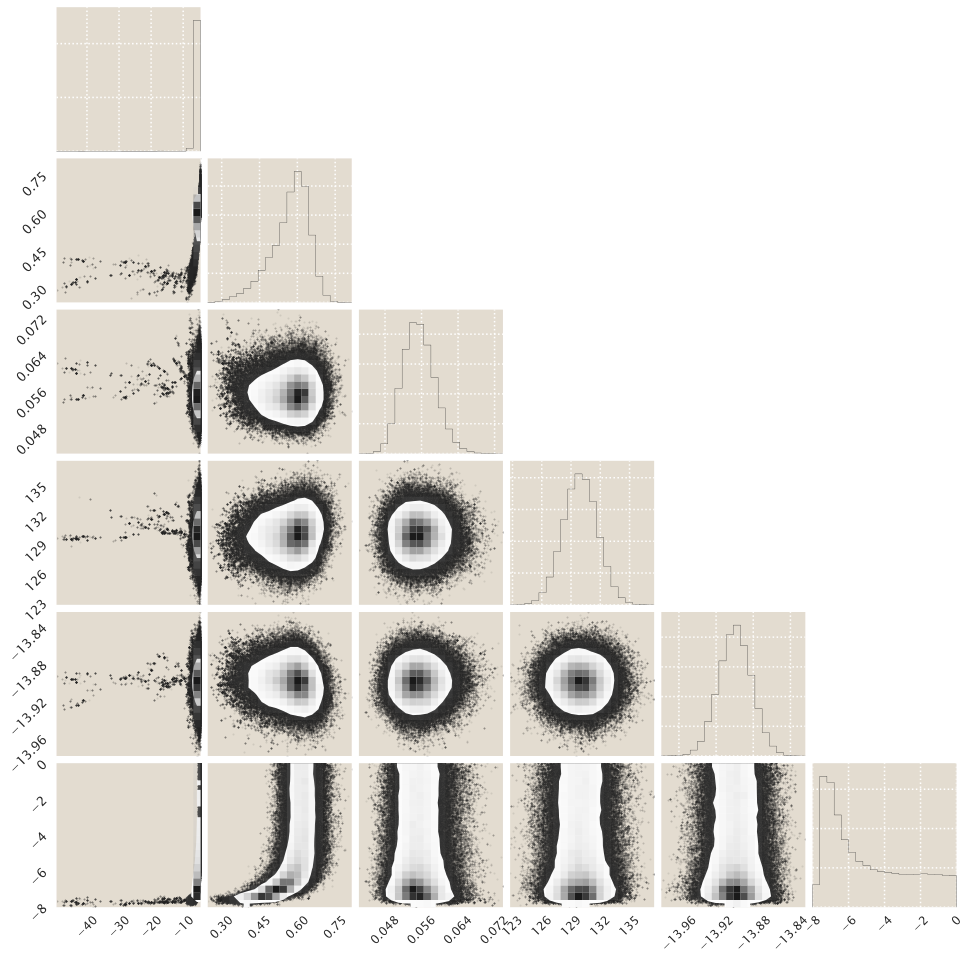

In [101]:
# Load the flat-chain
with open('../../data/mcmc/eRI_O2_R260.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=20, plot_contours=False)

In [102]:
# Load the flat-chain
with open('../../data/mcmc/eRI_O2_R260.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()
    
# Generate a Pandas Data Frame with the mcmc chain
index = np.concatenate([['ka', 'ki', 'sigma'],\
          [rbs[rbs.repressors==r].rbs.unique()[0] for r in \
              np.sort(rbs.repressors.unique())],
          [rbs[rbs.binding_energy==o].operator.unique()[0] for o in \
              np.sort(rbs.binding_energy.unique())],
          [rbs[rbs.binding_energy==o].operator.unique()[0] + '_inactive' for o in \
              np.sort(rbs.binding_energy.unique())]])

# Generate a data frame out of the MCMC chains
mcmc_rbs = pd.DataFrame(gauss_flatchain, columns=index)
mcmc_rbs['Ka'] = np.exp(-mcmc_rbs['ka'])
mcmc_rbs['Ki'] = np.exp(-mcmc_rbs['ki'])

# Generate data frame with mode values for each parameter
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
# Obtain the MAP for each parameter
param_fit = mcmc_rbs.loc[max_idx, :]
# Convert to data frame with column name mode
param_fit = param_fit.to_frame(name='mode')
# Generate parameter to save the hpd for each parameter
param_hpd = pd.DataFrame(columns=['hpd_min', 'hpd_max'])

# Loop through each parameter computing the 95% hpd
for column in mcmc_rbs:
    param_hpd = param_hpd.append(pd.Series(np.abs(mwc.hpd(mcmc_rbs[column], 0.95) - \
                                           param_fit.loc[column, 'mode']),
                               index=['hpd_min', 'hpd_max'], name=column))

# Combine the data frames into a single data frame
param_fit = pd.concat([param_fit, param_hpd], axis=1)
param_fit.round(2)

,mode,hpd_min,hpd_max
ka,-5.36,1.01,0.63
ki,0.55,0.14,0.15
sigma,0.05,0.01,0.01
RBS1027,129.93,3.41,3.45
O2,-13.90,0.03,0.04
O2_inactive,-6.82,0.90,6.27
Ka,213.22,106.02,352.29
Ki,0.58,0.08,0.09


# Running the MCMC with all the data

Having tested the functions we can now proceed to perform the MCMC using all the strains.

In [49]:
# Preprocess the data
unique_var, param_idx, data = mcmc_pre_process(df)

n_walkers = 50
n_burn = 500
n_steps = 8000
p0, n_dim = init_walkers(df, n_walkers, unique_var, param_idx)
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)

In [50]:
sample = False
if sample:
    #Do the burn in
    print('Performing the burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('Performing the MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/eRI_all_data_informative.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)

Performing the burn-in
Performing the MCMC


In [51]:
# Load the flat-chain
with open('../../data/mcmc/eRI_all_data_informative.pkl','rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# # Draw the corner plot
# fig = corner.corner(gauss_flatchain, bins=50, plot_contours=False,
#                     rasterized=True)

Let us now create a `DataFrame` out of the MCMC chains.

In [56]:
# Generate a Pandas Data Frame with the mcmc chain
index = np.concatenate([['ka', 'ki', 'sigma'],\
          [df[df.repressors==r].rbs.unique()[0] for r in \
              np.sort(df.repressors.unique())],
          [df[df.binding_energy==o].operator.unique()[0] for o in \
              np.sort(df.binding_energy.unique())],
          [df[df.binding_energy==o].operator.unique()[0] + '_inactive' for o in \
              np.sort(df.binding_energy.unique())]])

# Generate a data frame out of the MCMC chains
mcmc_df = pd.DataFrame(gauss_flatchain, columns=index)
mcmc_df['Ka'] = np.exp(-mcmc_df['ka'])
mcmc_df['Ki'] = np.exp(-mcmc_df['ki'])

# redfine the index with the new entries
index = mcmc_df.columns
mcmc_df.head()

,ka,ki,sigma,HG104,RBS1147,RBS446,RBS1027,RBS1,RBS1L,Oid,O1,O2,O3,Oid_inactive,O1_inactive,O2_inactive,O3_inactive,Ka,Ki
0,-5.298995,0.455740,0.087631,10.880603,32.133782,61.158862,130.770530,592.487609,842.485920,-17.022035,-15.278849,-13.887710,-9.682886,-10.090823,-8.394695,-6.971837,-2.788271,200.135509,0.633979
1,-5.294626,0.458860,0.088085,10.923223,32.181676,61.011001,130.806478,592.894516,842.026371,-17.020634,-15.283461,-13.888386,-9.684175,-10.088460,-8.393414,-6.973504,-2.789899,199.263171,0.632004
2,-5.294626,0.458860,0.088085,10.923223,32.181676,61.011001,130.806478,592.894516,842.026371,-17.020634,-15.283461,-13.888386,-9.684175,-10.088460,-8.393414,-6.973504,-2.789899,199.263171,0.632004
3,-5.294626,0.458860,0.088085,10.923223,32.181676,61.011001,130.806478,592.894516,842.026371,-17.020634,-15.283461,-13.888386,-9.684175,-10.088460,-8.393414,-6.973504,-2.789899,199.263171,0.632004
4,-5.294903,0.458947,0.088088,10.928272,32.212360,61.052046,130.857541,593.587214,842.089175,-17.020127,-15.284215,-13.888216,-9.684705,-10.087343,-8.393557,-6.972964,-2.790160,199.318262,0.631949


In [57]:
# Generate data frame with mode values for each parameter
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
# Obtain the MAP for each parameter
param_fit = mcmc_df.loc[max_idx, :]
# Convert to data frame with column name mode
param_fit = param_fit.to_frame(name='mode')
# Generate parameter to save the hpd for each parameter
param_hpd = pd.DataFrame(columns=['hpd_min', 'hpd_max'])

# Loop through each parameter computing the 95% hpd
for column in mcmc_df:
    param_hpd = param_hpd.append(pd.Series(np.abs(mwc.hpd(mcmc_df[column], 0.95) - \
                                           param_fit.loc[column, 'mode']),
                               index=['hpd_min', 'hpd_max'], name=column))

# Combine the data frames into a single data frame
param_fit = pd.concat([param_fit, param_hpd], axis=1)
param_fit.round(2)

,mode,hpd_min,hpd_max
ka,-5.81,0.12,0.20
ki,0.37,0.03,0.05
sigma,0.08,0.00,0.00
HG104,10.84,0.16,0.24
RBS1147,32.25,0.96,0.82
RBS446,62.94,1.69,1.20
RBS1027,128.24,1.64,2.51
RBS1,599.73,5.93,11.07
RBS1L,843.11,18.10,16.72
Oid,-17.06,0.03,0.05


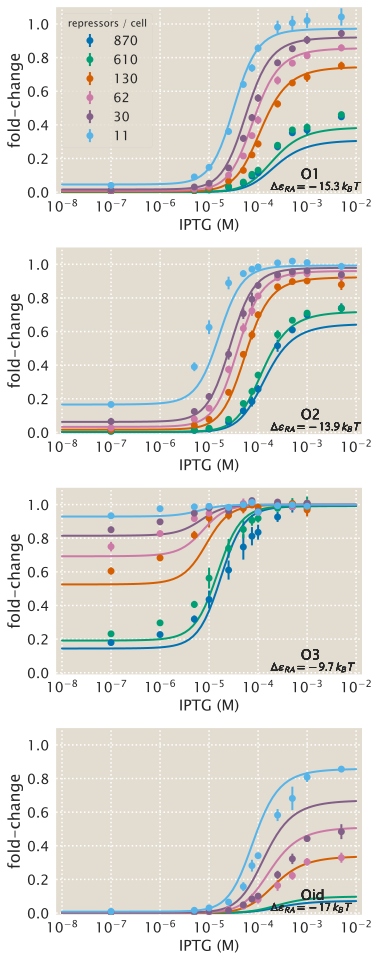

In [58]:
# map value of the parameters
map_param = param_fit['mode'].to_dict()

# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 75)

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O1', 'O2', 'O3', 'Oid']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17}

# Initialize the plot to set the size
fig,ax = plt.subplots(4, 1, figsize=(5.5, 13.5))

# Loop through operators
for i, op in enumerate(operators):
    data = df[df.operator==op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
        # plot the theory using the parameters from the fit.
        ax[i].plot(IPTG, fold_change_log_eRI(IPTG * 1E6, 
            ea=map_param['ka'], ei=map_param['ki'], 
            epsilon=4.5,
            R=map_param[rbs],
            epsilon_RA=map_param[op],
            epsilon_RI=map_param[op + '_inactive']),
            color=colors[j])

        # compute the mean value for each concentration
        fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())
        
        # plot the experimental data
        ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6, 
                       fc_mean, yerr=fc_err, fmt='o', 
                       label=df[df.rbs==rbs].repressors.unique()[0],
                       color=colors[j])
        # Add operator and binding energy labels.
        ax[i].text(0.8, 0.08, r'{0}'.format(op), transform=ax[i].transAxes, 
                fontsize=14)
        ax[i].text(0.7, 0.02,
                r'$\Delta\varepsilon_{RA} = %s\,k_BT$' %energies[op],
                transform=ax[i].transAxes, fontsize=12)
        ax[i].set_xscale('log')
        ax[i].set_xlabel('IPTG (M)', fontsize=15)
        ax[i].set_ylabel('fold-change', fontsize=16)
        ax[i].set_ylim([-0.01, 1.1])
        ax[i].tick_params(labelsize=14)
        ax[i].margins(0.02)
ax[0].legend(loc='upper left', title='repressors / cell')
# add plot letter labels
plt.tight_layout()

# Running the MCMC with less constrained priors

An interesting feature to explore is to see "how well we could fit the data" given that we truly allow all the parameters to be fit. We can simply do that by extending the $\sigma$ value on the priors for the repressor copy numbers and the binding energies. In this example we will try increasing the error that Hernan and Phillips originally infered.

Let's read the data and define this larger error.

In [104]:
# Define working directory
datadir = '../../data/'
# List files to be read
files = ['flow_master.csv', 'merged_Oid_data_foldchange.csv']
# Read flow cytometry data
df_Oid = pd.read_csv(datadir + files[1], comment='#')
# make an extra column to have consistent labeling
df_Oid['fold_change_A'] = df_Oid.fold_change
# Remove manually the outlier with an unphysical fold-change
df_Oid = df_Oid[df_Oid.fold_change_A <= 1]
# Read the flow cytometry data
df = pd.read_csv(datadir + files[0], comment='#')
# Attach both data frames into a single one
df = pd.concat([df, df_Oid])
# Drop rows containing NA values
df.dropna(axis=1, inplace=True)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]
# Restart index
df = df.reset_index()

#Define increased error
error_r = 3
error_e = 15
# Add the error columns to the data frame
df['delta_repressors'] = pd.Series([delta_R[df.iloc[x].rbs] * error_r for x\
                                    in np.arange(df.shape[0])])
df['delta_energy'] = pd.Series([delta_epsilon_r[x] * error_e for x in df.operator])

df[['repressors', 'delta_repressors', 'binding_energy', 'delta_energy']].tail(6)

,repressors,delta_repressors,binding_energy,delta_energy
2253,11,6,-17.0,3.0
2254,11,6,-17.0,3.0
2255,11,6,-17.0,3.0
2256,11,6,-17.0,3.0
2257,11,6,-17.0,3.0
2258,11,6,-17.0,3.0


In [105]:
# Preprocess the data
unique_var, param_idx, data = mcmc_pre_process(df)

n_walkers = 50
n_burn = 2500
n_steps = 5000
p0, n_dim = init_walkers(df, n_walkers, unique_var, param_idx)
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)

In [106]:
sample = True
if sample:
    #Do the burn in
    print('Performing the burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('Performing the MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/eRI_global_all_operators.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)

Performing the burn-in


/Users/razo/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/razo/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Performing the MCMC


In [111]:
# Load the flat-chain
with open('../../data/mcmc/eRI_global_all_operators.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Generate a Pandas Data Frame with the mcmc chain
index = np.concatenate([['ka', 'ki', 'sigma'],\
          [df[df.repressors==r].rbs.unique()[0] for r in \
              np.sort(df.repressors.unique())],
          [df[df.binding_energy==o].operator.unique()[0] for o in \
              np.sort(df.binding_energy.unique())],
          [df[df.binding_energy==o].operator.unique()[0] + '_inactive' for o in \
              np.sort(df.binding_energy.unique())]])

# Generate a data frame out of the MCMC chains
mcmc_df = pd.DataFrame(gauss_flatchain, columns=index)
mcmc_df['Ka'] = np.exp(-mcmc_df['ka'])
mcmc_df['Ki'] = np.exp(-mcmc_df['ki'])

# redfine the index with the new entries
index = mcmc_df.columns
mcmc_df.head()

,ka,ki,sigma,HG104,RBS1147,RBS446,RBS1027,RBS1,RBS1L,Oid,O1,O2,O3,Oid_inactive,O1_inactive,O2_inactive,O3_inactive,Ka,Ki
0,-5.439911,0.349810,0.069751,9.555811,37.831179,64.473890,127.567903,590.902943,799.198605,-17.761365,-15.384838,-13.609670,-9.303911,-9.352968,-0.307913,-6.196510,-5.422309,230.421607,0.704822
1,-5.438385,0.354713,0.069673,9.757134,37.652098,65.098270,128.004193,587.546622,793.835326,-17.721368,-15.389963,-13.602060,-9.311461,-9.589981,-0.722601,-6.221000,-5.445951,230.070246,0.701375
2,-5.438385,0.354713,0.069673,9.757134,37.652098,65.098270,128.004193,587.546622,793.835326,-17.721368,-15.389963,-13.602060,-9.311461,-9.589981,-0.722601,-6.221000,-5.445951,230.070246,0.701375
3,-5.432597,0.361358,0.070025,9.889751,37.611904,65.059244,128.474446,584.652763,790.199381,-17.711026,-15.398900,-13.603559,-9.323791,-9.611633,-1.383338,-6.205321,-5.518552,228.742554,0.696730
4,-5.432597,0.361358,0.070025,9.889751,37.611904,65.059244,128.474446,584.652763,790.199381,-17.711026,-15.398900,-13.603559,-9.323791,-9.611633,-1.383338,-6.205321,-5.518552,228.742554,0.696730


In [112]:
# Generate data frame with mode values for each parameter
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
# Obtain the MAP for each parameter
param_fit = mcmc_df.loc[max_idx, :]
# Convert to data frame with column name mode
param_fit = param_fit.to_frame(name='mode')
# Generate parameter to save the hpd for each parameter
param_hpd = pd.DataFrame(columns=['hpd_min', 'hpd_max'])

# Loop through each parameter computing the 95% hpd
for column in mcmc_df:
    param_hpd = param_hpd.append(pd.Series(np.abs(mwc.hpd(mcmc_df[column], 0.95) - \
                                           param_fit.loc[column, 'mode']),
                               index=['hpd_min', 'hpd_max'], name=column))

# Combine the data frames into a single data frame
param_fit = pd.concat([param_fit, param_hpd], axis=1)
param_fit.round(2)

,mode,hpd_min,hpd_max
ka,-5.41,0.10,0.06
ki,0.36,0.04,0.06
sigma,0.07,0.00,0.00
HG104,9.96,0.46,0.53
RBS1147,37.17,1.86,2.00
RBS446,65.97,3.28,2.64
RBS1027,129.80,4.58,5.41
RBS1,585.03,17.53,24.10
RBS1L,790.19,44.37,36.59
Oid,-17.67,0.32,0.21


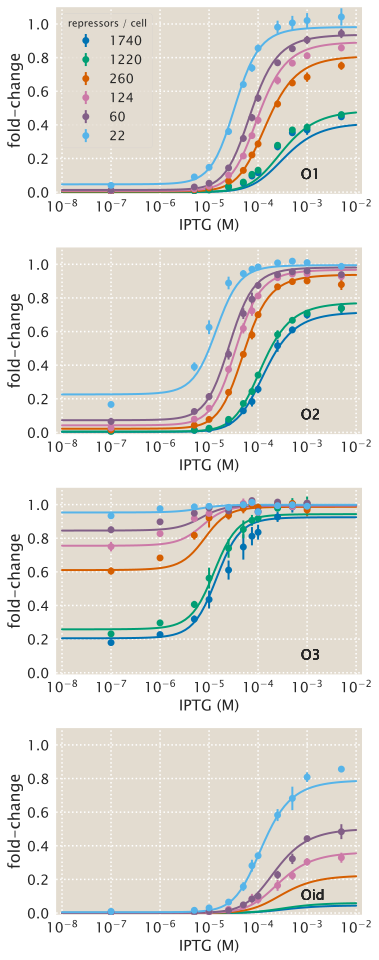

In [113]:
# map value of the parameters
map_param = param_fit['mode'].to_dict()

# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-8, -2, 75)

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O1', 'O2', 'O3', 'Oid']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17}

# Initialize the plot to set the size
fig,ax = plt.subplots(4, 1, figsize=(5.5, 13.5))

# Loop through operators
for i, op in enumerate(operators):
    data = df[df.operator==op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
        # plot the theory using the parameters from the fit.
        ax[i].plot(IPTG, fold_change_log_eRI(IPTG * 1E6, 
            ea=map_param['ka'], ei=map_param['ki'], 
            epsilon=4.5,
            R=map_param[rbs],
            epsilon_RA=map_param[op],
            epsilon_RI=map_param[op + '_inactive']),
            color=colors[j])

        # compute the mean value for each concentration
        fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())
        
        # plot the experimental data
        ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6, 
                       fc_mean, yerr=fc_err, fmt='o', 
                       label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                       color=colors[j])
        # Add operator and binding energy labels.
        ax[i].text(0.8, 0.08, r'{0}'.format(op), transform=ax[i].transAxes, 
                fontsize=14)
#         ax[i].text(0.7, 0.02,
#                 r'$\Delta\varepsilon_{RA} = %s\,k_BT$' %energies[op],
#                 transform=ax[i].transAxes, fontsize=12)
        ax[i].set_xscale('log')
        ax[i].set_xlabel('IPTG (M)', fontsize=15)
        ax[i].set_ylabel('fold-change', fontsize=16)
        ax[i].set_ylim([-0.01, 1.1])
        ax[i].tick_params(labelsize=14)
        ax[i].margins(0.02)
ax[0].legend(loc='upper left', title='repressors / cell')
# add plot letter labels
plt.tight_layout()

In [24]:
for value in param_fit.iterrows():
    print(value[0])
    if value[0] in df.rbs.unique():
        p_mode = value[1][0] * 2
        p_max = value[1][2] * 2
        p_min = value[1][1] * 2
        print('{0:.0f}^{{+{1:0.0f}}}_{{-{2:0.0f}}}'.format(p_mode, p_max, p_min))
    elif value[0] in df.operator.unique():
        p_mode = value[1][0]
        p_max = value[1][2]
        p_min = value[1][1]
        print('{0:.1f}^{{+{1:0.1f}}}_{{-{2:0.1f}}}'.format(p_mode, p_max, p_min))       
    else:
        p_mode = value[1][0]
        p_max = value[1][2]
        p_min = value[1][1]
        print('{0:.2f}^{{+{1:0.2f}}}_{{-{2:0.2f}}}'.format(p_mode, p_max, p_min))       
#         print('{0:.2f}^{{+{1:0.2f}}}_{{-{2:.2f}}}'.format(float('%.1g' % p_mode), 
#                                                           float('%.1g' % p_max), 
#                                                           float('%.1g' % p_min)))

ka
-5.31^{+0.05}_{-0.06}
ki
0.31^{+0.05}_{-0.05}
sigma
0.07^{+0.00}_{-0.00}
HG104
20^{+1}_{-1}
RBS1147
76^{+2}_{-5}
RBS446
130^{+6}_{-6}
RBS1027
257^{+9}_{-11}
RBS1
1181^{+40}_{-46}
RBS1L
1603^{+71}_{-92}
Oid
-17.7^{+0.1}_{-0.2}
O1
-15.2^{+0.1}_{-0.1}
O2
-13.5^{+0.1}_{-0.1}
O3
-9.4^{+0.1}_{-0.1}
Ka
202.59^{+13.38}_{-9.16}
Ki
0.73^{+0.04}_{-0.04}
